I chose a dataset of Bitcoin addresses linked to ransomware attacks because it combines the fields of cryptography and blockchain with cybersecurity, and i think that the cryptography is an interesting subject.
The dataset enables a good analysis of address features and their economic activity, detection of anomalies, building models to identify malicious addresses, and exploring behavioral patterns of ransomware attacks.
Also, since it's based on real cybersecurity research, the analysis feels practical and relevant to real-world scenarios.

System Stage:

File Name: BitcoinHeistData

File Source: The BitcoinHeist Ransomware Address Dataset was published on **Kaggle** by the user "sapere0", based on research by Tai et al.

Link to the data set: https://www.kaggle.com/datasets/sapere0/bitcoinheist-ransomware-dataset

Size: 224MB

Type: CSV

Number Of Lines: We will count it in using pandas later.

* The filename and file extension do not appear to be suspicious.


### Dataset Column Descriptions (BitcoinHeistData.csv)

- **address**: The Bitcoin wallet address that received money. These addresses are usually used by ransomware attackers.

- **year**: The year when the address was last active in the dataset.

- **day**: The day of the year (1 to 365) when the address appeared in the snapshot. Day 1 = Jan 1st, Day 365 = Dec 31st.

- **length**: Represents the number of "mixing rounds", how often coins were sent and received through new addresses.

- **weight**: Measures how much coin merging happened. If many small inputs were combined into one output, the weight will be high.

- **count**: Number of transactions that merged multiple sources of funds.

- **looped**: Number of full coin "loops", when coins were split, sent through different paths, and then merged back into one address. This can be a sign of laundering.

- **neighbors**: Number of other Bitcoin addresses that sent money to or received money from this address. High values suggest the address is part of a wider transaction network.

- **income**: Total amount of money received by the address, in satoshis (1 Bitcoin = 100 million satoshis). This shows how much ransom money was collected.

- **label**: The name of the ransomware family that used this address (`cryptolocker`, `cerber`, ...). If it says `white`, the address is not known to be ransomware.

* I found 1 version on kaggle.

### Meta Data:

In [2]:
import pandas as pd
import os
import re

# Extended phishing bait keywords
phishing_keywords = [
    "phish", "login", "bank", "account", "invoice", "paypal", "secure", "security", "verify", "update", "billing"]

# Regex patterns for leetspeak substitutions
leet_patterns = {
    "a": "[a@]",
    "e": "[e3]",
    "i": "[i1!|]",
    "o": "[o0]",
    "s": "[s5$]",
    "l": "[l1!|]",
    "t": "[t7+]",
    "ph": "(ph|f)",
}

# Function to turn keyword into a regex with leet support
def leetspeak_pattern(word):
    pattern = ""
    i = 0
    while i < len(word):
        # Special case for 'ph'
        if word[i:i+2] == "ph":
            pattern += leet_patterns["ph"]
            i += 2
        else:
            pattern += leet_patterns.get(word[i], word[i])
            i += 1
    return pattern

# Build regex for all phishing keywords
phishing_regexes = [re.compile(leetspeak_pattern(keyword), re.IGNORECASE) for keyword in phishing_keywords]

# Final filename red flag checker
def check_filename_red_flags(filename):
    red_flags = []

    name, ext = os.path.splitext(filename)

    # 1. Multiple extensions (e.g., invoice.pdf.exe)
    if filename.count('.') > 1:
        red_flags.append("Multiple dots (suspicious extensions)")

    # 2. Known phishing bait words with leetspeak
    for regex in phishing_regexes:
        if regex.search(filename):
            red_flags.append("Contains phishing-style name")

    # 3. Random character strings (hash-like)
    if re.fullmatch(r"[a-zA-Z0-9]{8,}", name) and not re.search(r"[aeiou]{2,}", name, re.IGNORECASE):
        red_flags.append("Random character string")

    # 4. Executable disguised as something else
    if filename.lower().endswith((".jpg.exe", ".png.exe", ".pdf.exe", ".docx.exe")):
        red_flags.append("Executable disguised as document or image")

    return red_flags

def check_size_per_row(filepath, min_bytes_per_row=20, max_bytes_per_row=10000):
    file_size = os.path.getsize(filepath)  # in bytes

    try:
        df = pd.read_csv(filepath)
        row_count = len(df)
        if row_count == 0:
            return "Empty file (0 rows)"

        size_per_row = file_size / row_count

        if size_per_row < min_bytes_per_row:
            return f"Too small: {size_per_row:.1f} bytes/row"
        elif size_per_row > max_bytes_per_row:
            return f"Too large: {size_per_row:.1f} bytes/row"
        else:
            return f"OK: {size_per_row:.1f} bytes/row"

    except Exception as e:
        return f"Error reading file: {e}"


# Optional: Show full float precision
pd.set_option('display.float_format', '{:.20f}'.format)

# Set the dataset folder path
folder_path = "Data Set"

# Loop over all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        print(f"\nProcessing file: {filename}")
        print("=" * 60)

        # Load CSV safely with float parsing
        try:
            df = pd.read_csv(file_path, index_col=False, dtype={'weight': float, 'income': float})
        except Exception as e:
            print(f"Failed to read {filename}: {e}")
            continue

        flags = check_filename_red_flags(filename)
        if flags:
            print(f"\nRed flags in filename: {filename}")
            for flag in flags:
                print(f"  - {flag}")
        else:
            print(f"\nNo name red flags found in filename: {filename}")

        result = check_size_per_row(file_path)
        print(f"File size check result: {result}")
        
        # Check for missing values
        print("\nMissing values per column:")
        print(df.isnull().sum())

        # Check data types
        print("\nData types:")
        print(df.dtypes)

        # Count unique values
        print("\nUnique values per column:")
        for col in df.columns:
            print(f"{col}: {df[col].nunique()} unique values")

        # Look for special values: -999 or 'unknown'
        print("\nChecking for special values (-999 or 'unknown'):")
        mask = (df == -999).any(axis=1) | (df.astype(str) == "unknown").any(axis=1)
        special_values = df[mask].copy()
        special_values["csv_row_number"] = special_values.index + 2

        print(f"Rows with special values: {len(special_values)}")

        # Display them (if any)
        if not special_values.empty:
            cols = ["csv_row_number"] + [col for col in special_values.columns if col != "csv_row_number"]
            special_values = special_values[cols]

            with pd.option_context('display.max_columns', None,
                                   'display.max_colwidth', None,
                                   'display.max_rows', None,
                                   'display.expand_frame_repr', False):
                display(special_values)

        # Check for zero income values
        if "income" in df.columns:
            zero_income = df[df["income"] == 0]
            print(f"\nAddresses with zero income: {len(zero_income)}")

        # Print total row count
        print(f"\nNumber of rows in the CSV file: {len(df)}")
        print("=" * 60)



Processing file: BitcoinHeistData.csv

No name red flags found in filename: BitcoinHeistData.csv
File size check result: OK: 80.9 bytes/row

Missing values per column:
address      0
year         0
day          0
length       0
weight       0
count        0
looped       0
neighbors    0
income       0
label        0
dtype: int64

Data types:
address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object

Unique values per column:
address: 2631095 unique values
year: 8 unique values
day: 365 unique values
length: 73 unique values
weight: 784927 unique values
count: 11572 unique values
looped: 10168 unique values
neighbors: 814 unique values
income: 1866365 unique values
label: 29 unique values

Checking for special values (-999 or 'unknown'):
Rows with special values: 4


,csv_row_number,address,year,day,length,weight,count,looped,neighbors,income,label
2566168,2566170,unknown,2017,345,144,146.13774144540099086953,5191,4812,1192,662525717815.00000000000000000000,white
2682857,2682859,unknown,2018,97,144,1827.77883521448006831633,4772,4772,7589,3097053880245.00000000000000000000,white
2807623,2807625,unknown,2018,221,144,1866.71672921494996444380,5680,5680,11746,10678161295882.00000000000000000000,white
2879952,2879954,unknown,2018,294,144,1943.74879331340002863726,3975,3975,12920,6510062177369.00000000000000000000,white



Addresses with zero income: 0

Number of rows in the CSV file: 2916697


### I will display some lines of the file "BitcoinHeistData.csv" to show an example.

In [3]:
df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.00833333333333330026,1,0,2,100050000.00000000000000000000,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.00024414062500000000,1,0,1,100000000.00000000000000000000,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.00000000000000000000,1,0,2,200000000.00000000000000000000,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.00390625000000000000,1,0,2,71200000.00000000000000000000,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.07284840719899310368,456,0,1,200000000.00000000000000000000,princetonLocky


### Columns Distributions:

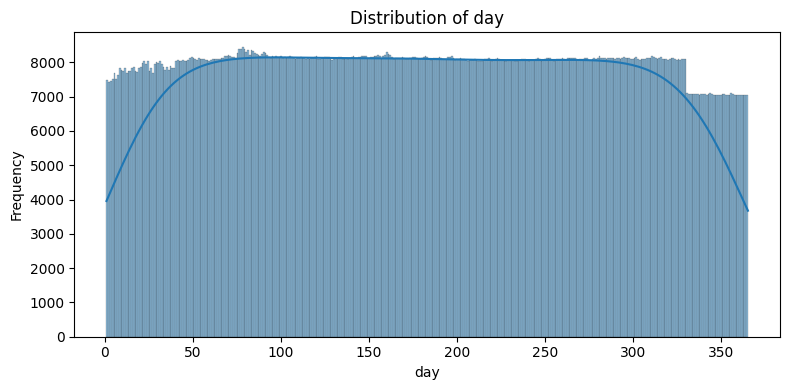

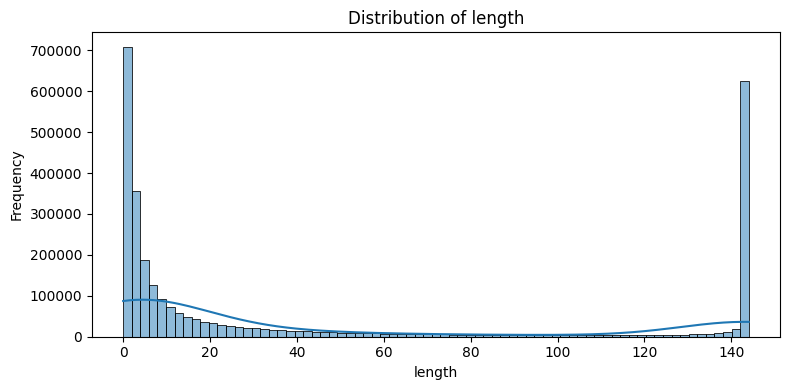

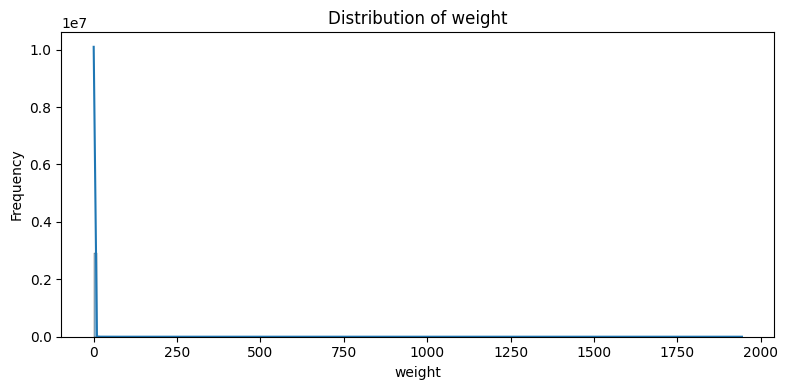

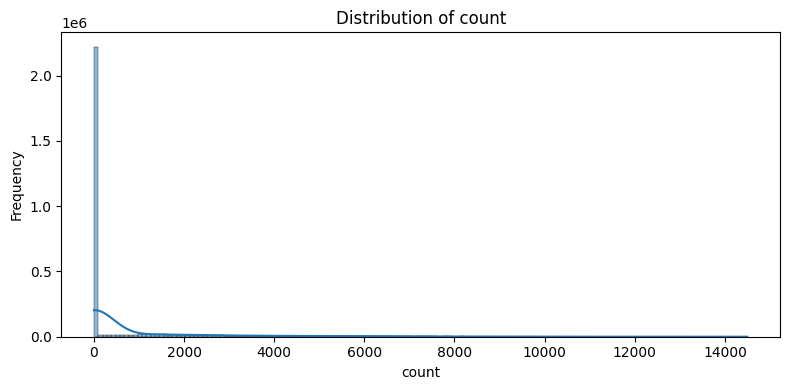

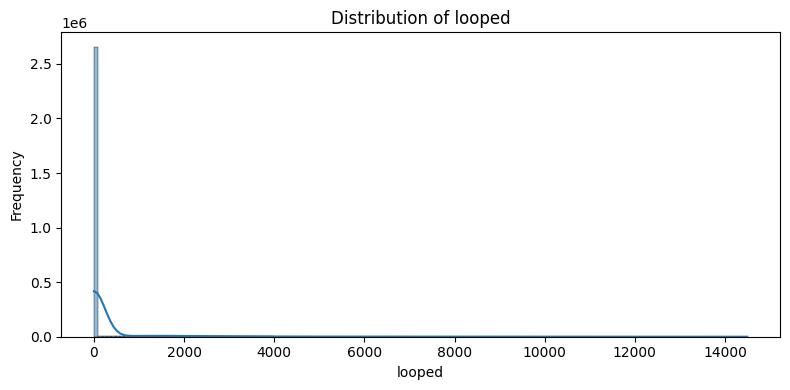

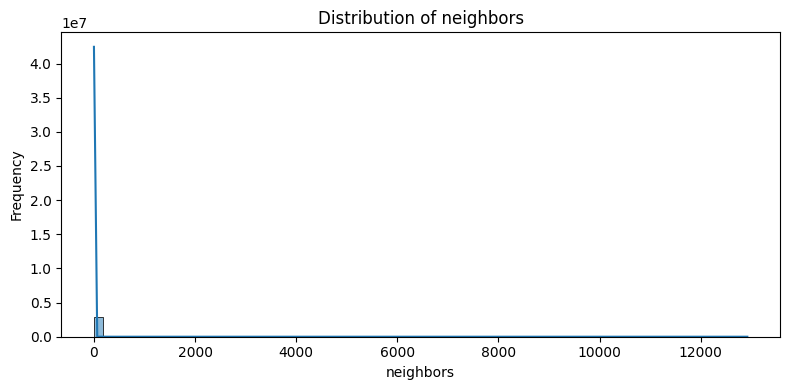

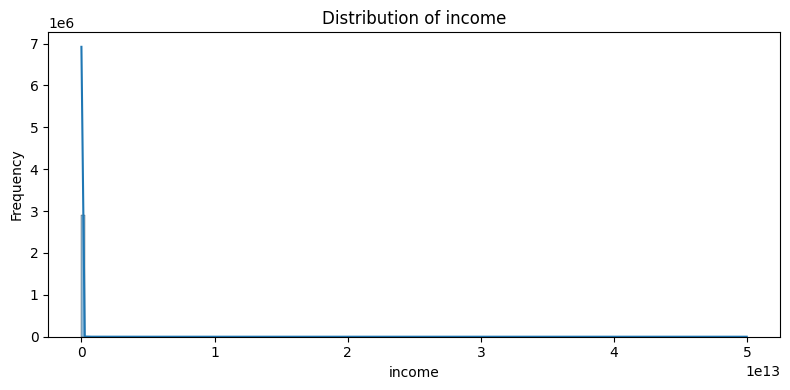

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(df, column, bins_num=100):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], bins=bins_num, kde=True, kde_kws={'bw_adjust': 5.0})
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_histogram(df, 'day', bins_num=365)
plot_histogram(df, 'length', bins_num=73)
plot_histogram(df, 'weight', bins_num=200)
plot_histogram(df, 'count', bins_num=150)
plot_histogram(df, 'looped', bins_num=150)
plot_histogram(df, 'neighbors', bins_num=75)
plot_histogram(df, 'income', bins_num=200)
    

### key summary statistics:

In [5]:
df.describe()

,year,day,length,weight,count,looped,neighbors,income
count,2916697.00000000000000000000,2916697.00000000000000000000,2916697.00000000000000000000,2916697.00000000000000000000,2916697.00000000000000000000,2916697.00000000000000000000,2916697.00000000000000000000,2916697.00000000000000000000
mean,2014.47501128845397033729,181.45721101643400174908,45.00859293920485981744,0.54551923416400205369,721.64464289571390054334,238.50669884461771630413,2.20651613794645085065,4464889007.18617153167724609375
std,2.25739755208802117536,104.01183576694086241332,58.98236229927723428546,3.67425525559670074216,1689.67579382838221135898,966.32168581933126461081,17.91876507824665054613,162685960669.34802246093750000000
min,2011.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,1.00000000000000000000,30000000.00000000000000000000
25%,2013.00000000000000000000,92.00000000000000000000,2.00000000000000000000,0.02148437500062089917,1.00000000000000000000,0.00000000000000000000,1.00000000000000000000,74285590.00000000000000000000
50%,2014.00000000000000000000,181.00000000000000000000,8.00000000000000000000,0.25000000000000000000,1.00000000000000000000,0.00000000000000000000,2.00000000000000000000,199998518.00000000000000000000
75%,2016.00000000000000000000,271.00000000000000000000,108.00000000000000000000,0.88194821266496103984,56.00000000000000000000,0.00000000000000000000,2.00000000000000000000,994000000.00000000000000000000
max,2018.00000000000000000000,365.00000000000000000000,144.00000000000000000000,1943.74879331340002863726,14497.00000000000000000000,14496.00000000000000000000,12920.00000000000000000000,49964398238996.00000000000000000000


### Statistic Detour:


Column: day
Mean: 181.46
Median: 181.00
Std: 104.01
Min: 1.00
Max: 365.00
Skewness: 0.01
Kurtosis: 1.81
Pearson Skewness: 0.01
IQR anomalies: 0
3*STD anomalies: 0
MAD anomalies: 0


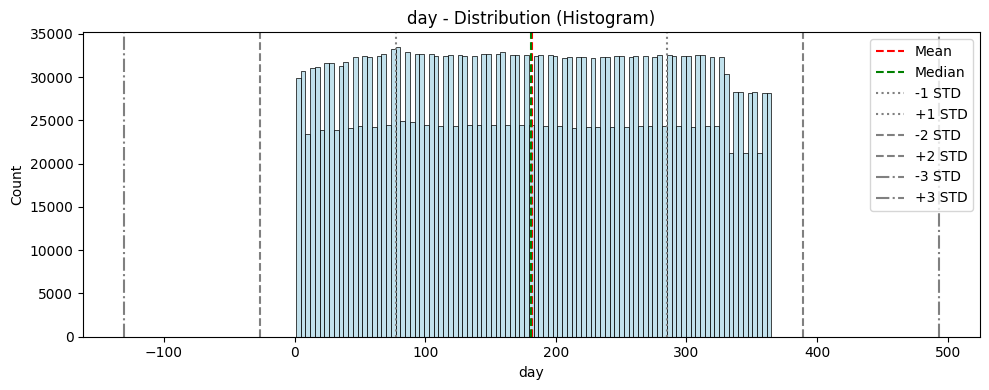

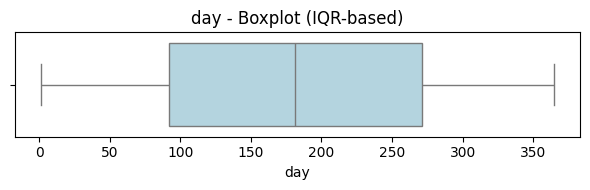


Column: length
Mean: 45.01
Median: 8.00
Std: 58.98
Min: 0.00
Max: 144.00
Skewness: 0.92
Kurtosis: 2.03
Pearson Skewness: 1.88
IQR anomalies: 0
3*STD anomalies: 0
MAD anomalies: 1009759


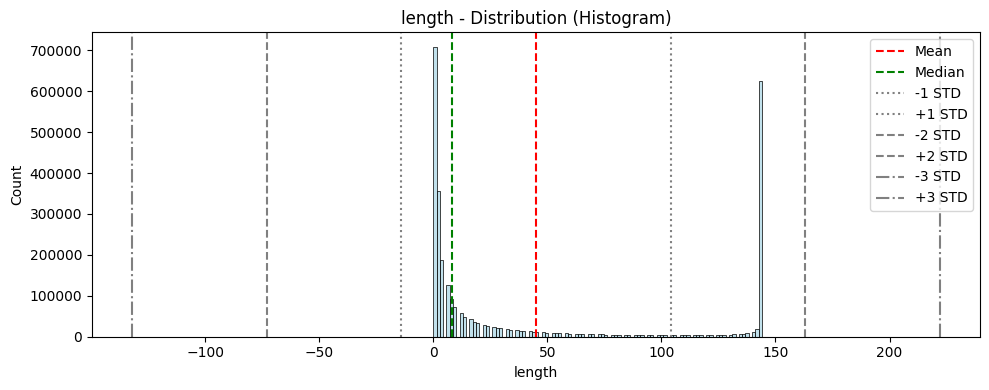

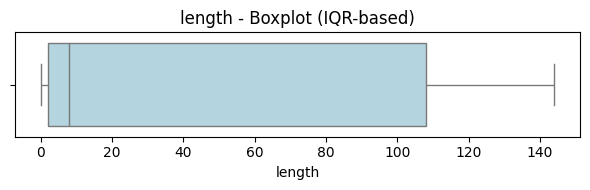


Column: weight
Mean: 0.55
Median: 0.25
Std: 3.67
Min: 0.00
Max: 1943.75
Skewness: 243.02
Kurtosis: 102691.79
Pearson Skewness: 0.24
IQR anomalies: 55006
3*STD anomalies: 5305
MAD anomalies: 717549


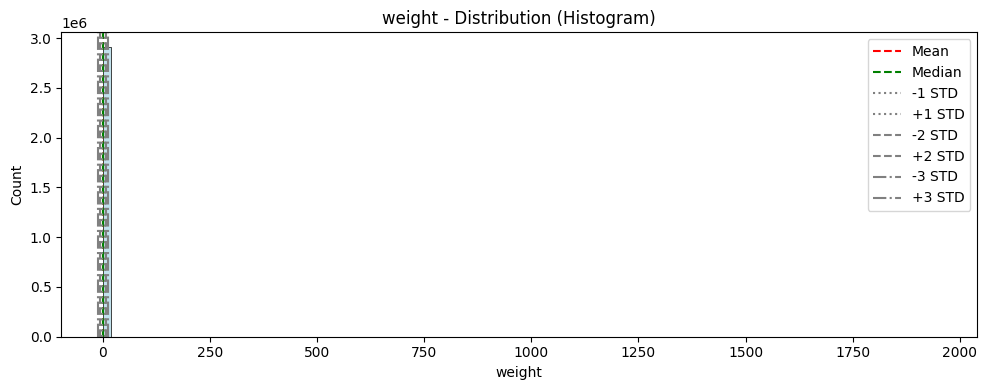

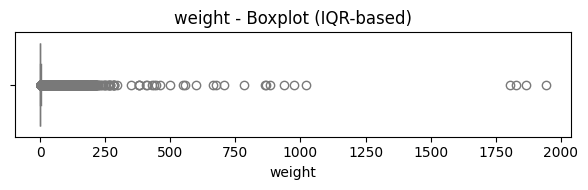


Column: count
Mean: 721.64
Median: 1.00
Std: 1689.68
Min: 1.00
Max: 14497.00
Skewness: 2.93
Kurtosis: 12.42
Pearson Skewness: 1.28
IQR anomalies: 688188
3*STD anomalies: 91373
MAD anomalies: 1243147


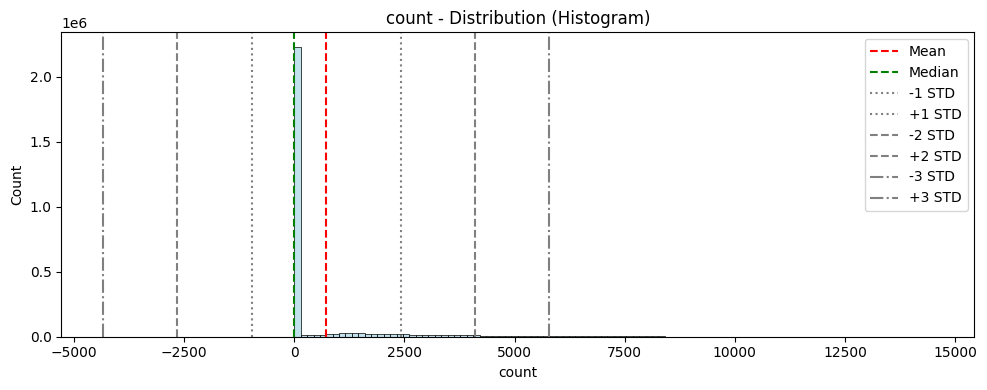

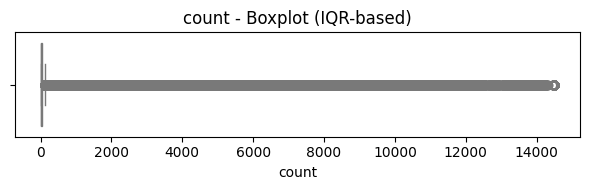


Column: looped
Mean: 238.51
Median: 0.00
Std: 966.32
Min: 0.00
Max: 14496.00
Skewness: 5.52
Kurtosis: 40.24
Pearson Skewness: 0.74
IQR anomalies: 411820
3*STD anomalies: 73748
MAD anomalies: 411820


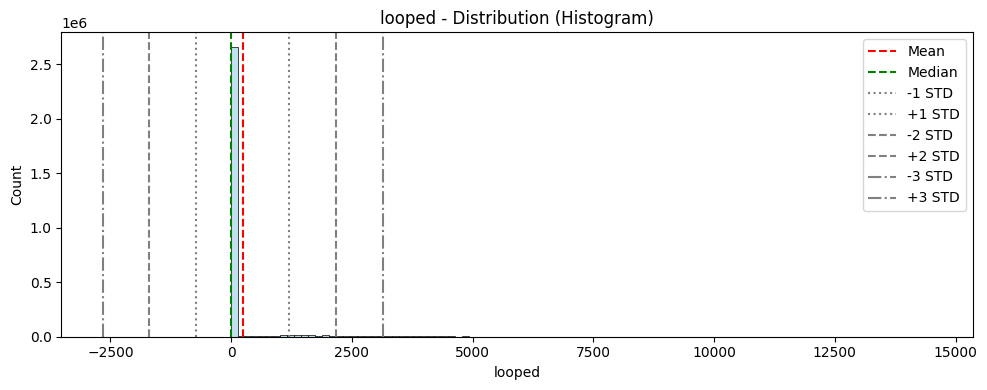

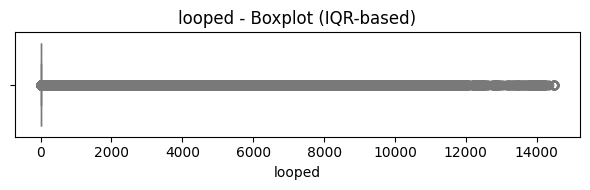


Column: neighbors
Mean: 2.21
Median: 2.00
Std: 17.92
Min: 1.00
Max: 12920.00
Skewness: 293.58
Kurtosis: 171458.60
Pearson Skewness: 0.03
IQR anomalies: 114659
3*STD anomalies: 3090
MAD anomalies: 1058413


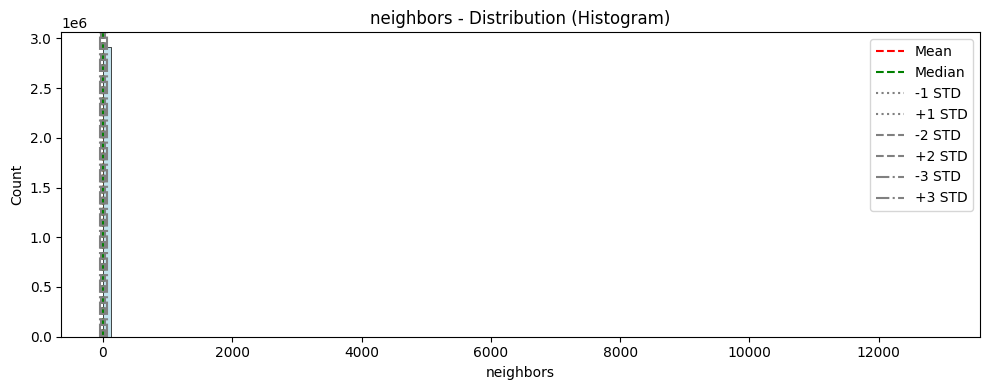

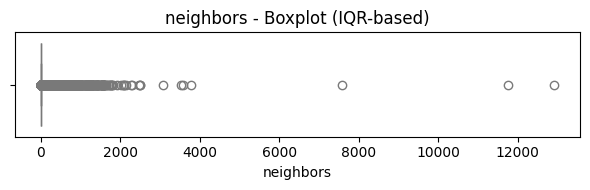


Column: income
Mean: 4464889007.19
Median: 199998518.00
Std: 162685932780.61
Min: 30000000.00
Max: 49964398238996.00
Skewness: 228.37
Kurtosis: 62541.32
Pearson Skewness: 0.08
IQR anomalies: 430677
3*STD anomalies: 2844
MAD anomalies: 872933


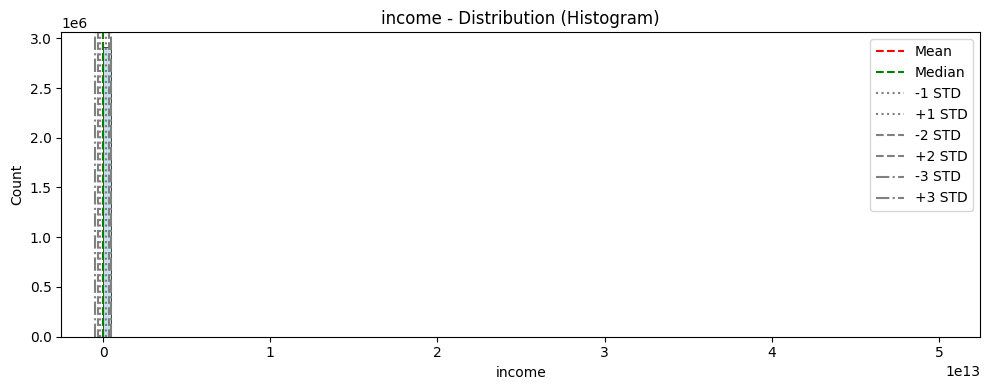

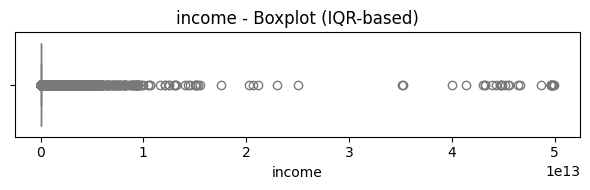


Most common address: 1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU (420 occurrences, 0.01%)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode

# Columns to analyze
interested_cols = ['day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']

# Describe distribution and visualize
def describe_distribution(df, column):
    data = df[column].dropna()
    n = len(data)
    mean = data.mean()
    std = data.std(ddof=0)

    print(f"\nColumn: {column}")
    print(f"Mean: {mean:.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Std: {std:.2f}")
    print(f"Min: {data.min():.2f}")
    print(f"Max: {data.max():.2f}")

    # Manual Skewness and Kurtosis
    skew = np.sum(((data - mean) / std) ** 3) / n
    kurtosis = np.sum(((data - mean) / std) ** 4) / n
    pearson_skew = 3 * (mean - data.median()) / std

    print(f"Skewness: {skew:.2f}")
    print(f"Kurtosis: {kurtosis:.2f}")
    print(f"Pearson Skewness: {pearson_skew:.2f}")

    # Quantiles
    quantiles = data.quantile([0.01, 0.25, 0.5, 0.75, 0.99])

    # IQR Method
    Q1 = quantiles[0.25]
    Q3 = quantiles[0.75]
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR
    iqr_anomalies = data[(data < lower_iqr) | (data > upper_iqr)]
    print(f"IQR anomalies: {len(iqr_anomalies)}")

    # 3*STD Method
    lower_std = mean - 3 * std
    upper_std = mean + 3 * std
    std_anomalies = data[(data < lower_std) | (data > upper_std)]
    print(f"3*STD anomalies: {len(std_anomalies)}")

    # MAD Method
    median = data.median()
    mad = np.median(np.abs(data - median))
    lower_mad = median - 3 * mad
    upper_mad = median + 3 * mad
    mad_anomalies = data[(data < lower_mad) | (data > upper_mad)]
    print(f"MAD anomalies: {len(mad_anomalies)}")

    # Plots:

    # Histogram
    plt.figure(figsize=(10, 4))
    sns.histplot(data, bins=100, color='lightblue')

    # Central tendency
    plt.axvline(mean, color='red', linestyle='--', label='Mean')
    plt.axvline(median, color='green', linestyle='--', label='Median')

    # Standard deviation bounds
    plt.axvline(mean - std, color='gray', linestyle=':', label='-1 STD')
    plt.axvline(mean + std, color='gray', linestyle=':', label='+1 STD')
    plt.axvline(mean - 2 * std, color='gray', linestyle='--', label='-2 STD')
    plt.axvline(mean + 2 * std, color='gray', linestyle='--', label='+2 STD')
    plt.axvline(mean - 3 * std, color='gray', linestyle='-.', label='-3 STD')
    plt.axvline(mean + 3 * std, color='gray', linestyle='-.', label='+3 STD')

    plt.title(f"{column} - Distribution (Histogram)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Boxplot for IQR visualization
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=data, color='lightblue')
    plt.title(f"{column} - Boxplot (IQR-based)")
    plt.tight_layout()
    plt.show()


# Run for each selected column
for col in interested_cols:
    describe_distribution(df, col)

# Address mode info
address_mode = mode(df['address'])
address_mode_number = df['address'].value_counts().get(address_mode, 0)
address_mode_percentage = (address_mode_number / len(df)) * 100
print(f"\nMost common address: {address_mode} ({address_mode_number} occurrences, {address_mode_percentage:.2f}%)")



Column: weight
Mean: 0.55
Median: 0.25
Std: 3.67
Min: 0.00
Max: 1943.75
Skewness: 243.02
Kurtosis: 102691.79
Pearson Skewness: 0.24
IQR anomalies: 55006
3*STD anomalies: 5305
MAD anomalies: 717549


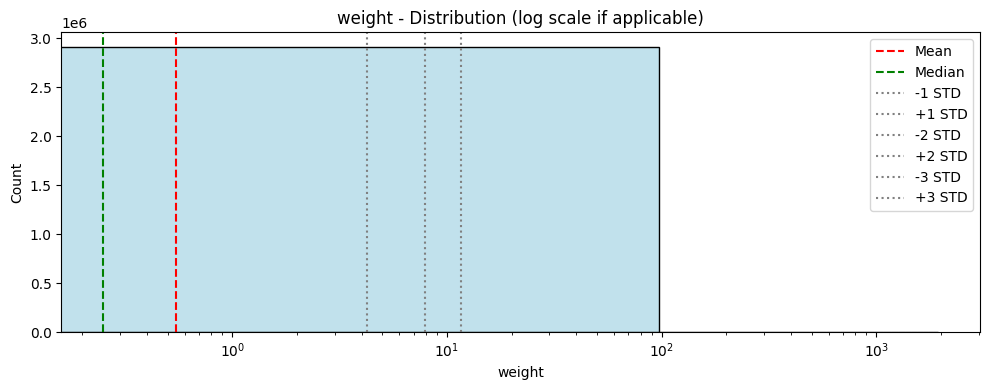

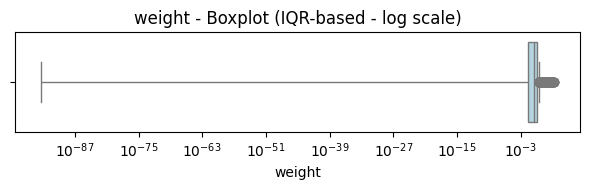


Column: count
Mean: 721.64
Median: 1.00
Std: 1689.68
Min: 1.00
Max: 14497.00
Skewness: 2.93
Kurtosis: 12.42
Pearson Skewness: 1.28
IQR anomalies: 688188
3*STD anomalies: 91373
MAD anomalies: 1243147


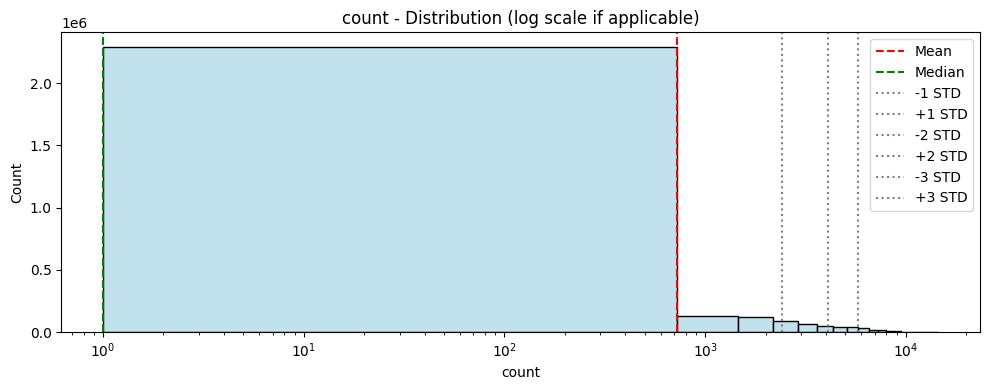

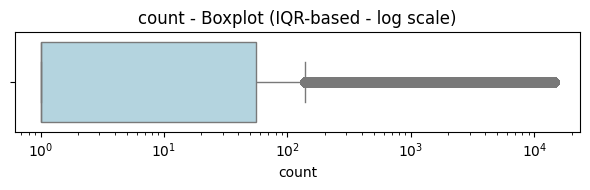


Column: looped
Mean: 238.51
Median: 0.00
Std: 966.32
Min: 0.00
Max: 14496.00
Skewness: 5.52
Kurtosis: 40.24
Pearson Skewness: 0.74
IQR anomalies: 411820
3*STD anomalies: 73748
MAD anomalies: 411820


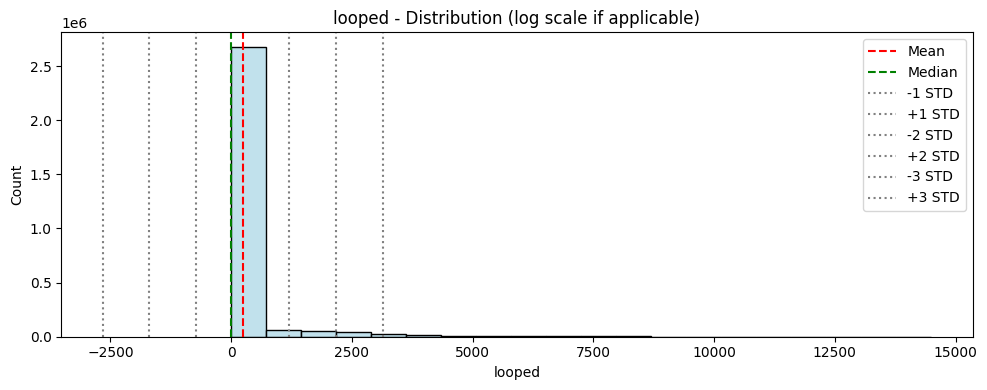

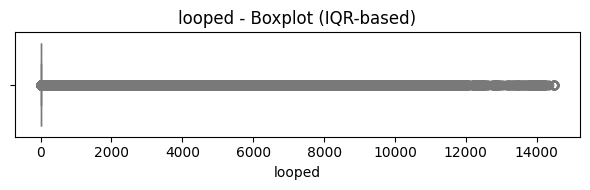


Column: neighbors
Mean: 2.21
Median: 2.00
Std: 17.92
Min: 1.00
Max: 12920.00
Skewness: 293.58
Kurtosis: 171458.60
Pearson Skewness: 0.03
IQR anomalies: 114659
3*STD anomalies: 3090
MAD anomalies: 1058413


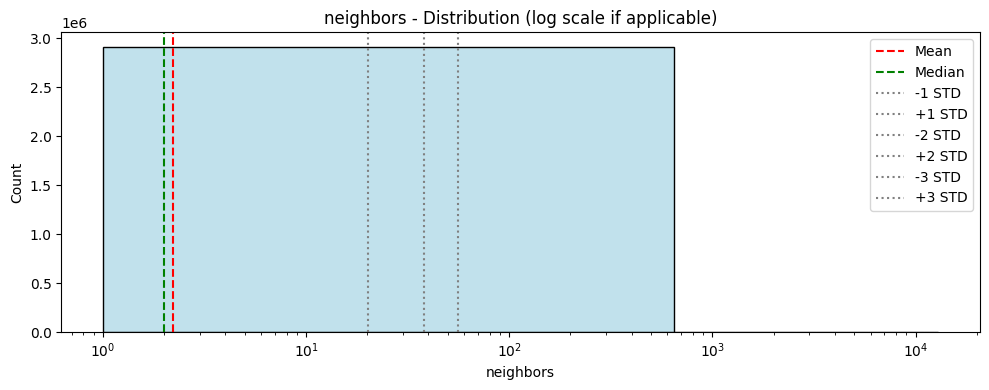

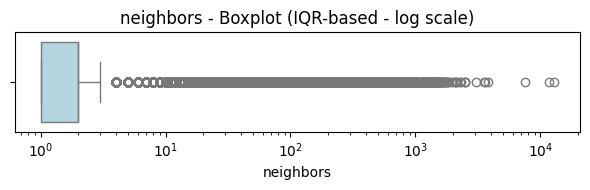


Column: income
Mean: 4464889007.19
Median: 199998518.00
Std: 162685932780.61
Min: 30000000.00
Max: 49964398238996.00
Skewness: 228.37
Kurtosis: 62541.32
Pearson Skewness: 0.08
IQR anomalies: 430677
3*STD anomalies: 2844
MAD anomalies: 872933


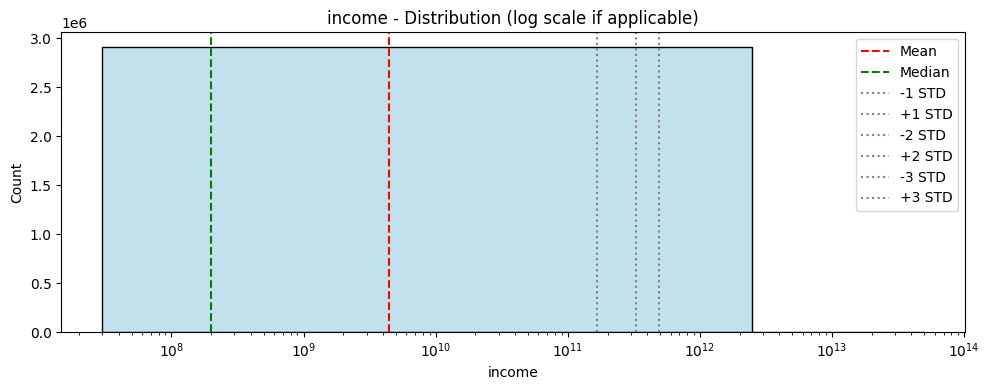

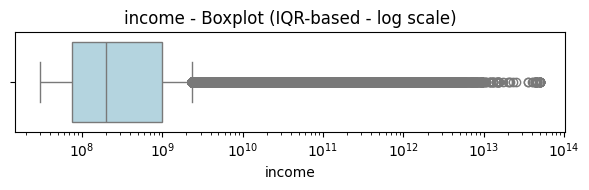

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def describe_distribution_with_log(df, column):
    data = df[column].dropna()
    n = len(data)
    mean = data.mean()
    std = data.std(ddof=0)

    print(f"\nColumn: {column}")
    print(f"Mean: {mean:.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Std: {std:.2f}")
    print(f"Min: {data.min():.2f}")
    print(f"Max: {data.max():.2f}")

    skew = np.sum(((data - mean) / std) ** 3) / n
    kurtosis = np.sum(((data - mean) / std) ** 4) / n
    pearson_skew = 3 * (mean - data.median()) / std

    print(f"Skewness: {skew:.2f}")
    print(f"Kurtosis: {kurtosis:.2f}")
    print(f"Pearson Skewness: {pearson_skew:.2f}")

    quantiles = data.quantile([0.01, 0.25, 0.5, 0.75, 0.99])
    Q1, Q3 = quantiles[0.25], quantiles[0.75]
    IQR = Q3 - Q1
    lower_iqr, upper_iqr = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    iqr_anomalies = data[(data < lower_iqr) | (data > upper_iqr)]
    print(f"IQR anomalies: {len(iqr_anomalies)}")

    lower_std, upper_std = mean - 3 * std, mean + 3 * std
    std_anomalies = data[(data < lower_std) | (data > upper_std)]
    print(f"3*STD anomalies: {len(std_anomalies)}")

    median = data.median()
    mad = np.median(np.abs(data - median))
    lower_mad, upper_mad = median - 3 * mad, median + 3 * mad
    mad_anomalies = data[(data < lower_mad) | (data > upper_mad)]
    print(f"MAD anomalies: {len(mad_anomalies)}")

    # Histogram (log-scaled x-axis if applicable)
    plt.figure(figsize=(10, 4))
    sns.histplot(data, bins=20, color='lightblue')

    use_log = (data > 0).all()
    if use_log:
        plt.xscale('log')

    plt.axvline(mean, color='red', linestyle='--', label='Mean')
    plt.axvline(median, color='green', linestyle='--', label='Median')

    for i in range(1, 4):
        plt.axvline(mean - i * std, color='gray', linestyle=':', label=f'-{i} STD')
        plt.axvline(mean + i * std, color='gray', linestyle=':', label=f'+{i} STD')

    plt.title(f"{column} - Distribution (log scale if applicable)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Boxplot (IQR visualization, log-scaled x if applicable)
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=data, color='lightblue')
    if use_log:
        plt.xscale('log')
    plt.title(f"{column} - Boxplot (IQR-based{' - log scale' if use_log else ''})")
    plt.tight_layout()
    plt.show()

interested_cols = ['weight', 'count', 'looped', 'neighbors', 'income']

for col in interested_cols:
    describe_distribution_with_log(df, col)


# Explanation:
The above function `describe_distribution` provides a comprehensive summary of each numerical column's statistical properties.
It calculates key metrics such as mean, median, standard deviation, and identifies anomalies using three different methods:
- IQR (Interquartile Range)
- 3*STD (Standard Deviation)
- MAD (Median Absolute Deviation)

Visualizations include:
- A histogram with lines marking the mean, median, IQR bounds, and standard deviation thresholds.
- A quantile plot to show the value distribution across percentiles.

These analyses are useful for detecting skewness, abnormal distributions, and potential data entry errors.

However, in some columns we observe that the histogram is very compressed, with most values clustered together
and a few extreme values far away. In such cases, the IQR, STD, and MAD boundaries may not appear clearly in the plot,
or they may visually overlap due to lack of scale separation. This usually happens when:
- The data is heavily skewed or has anomalies with very large magnitudes.
- The value range is extremely wide, so visual indicators get pushed to the edges or fall outside the visible range.

In such cases, it's useful to consider log-scaling the x-axis, so I did that also by optionally applying a logarithmic transformation to the x-axis, which helps to spread out tightly clustered values and bring extreme anomalies into view

Also when using the IQR method, the boxplot can look strange if the data is skewed or concentrated in one area. This creates many outliers, shown as small circles, and when there are too many, they stack into a gray line outside the IQR bounds. Using log scale in the plot helps show the boxplot more clearly in these cases.


### Association

In [30]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def compute_cramers_v(df, col1, col2, bins=4):
    temp_df = df[[col1, col2]].copy()

    # Discretize numeric columns
    if pd.api.types.is_numeric_dtype(temp_df[col1]):
        temp_df[col1] = pd.qcut(temp_df[col1], bins, duplicates='drop')
    if pd.api.types.is_numeric_dtype(temp_df[col2]):
        temp_df[col2] = pd.qcut(temp_df[col2], bins, duplicates='drop')

    # Create contingency table
    contingency_table = pd.crosstab(temp_df[col1], temp_df[col2])

    # Check table shape to prevent division by zero
    r, k = contingency_table.shape
    if min(r, k) <= 1:
        return np.nan  # Not enough categories to compute V

    # Chi-squared test
    chi2, _, _, _ = chi2_contingency(contingency_table)

    # Cramer's V calculation
    n = contingency_table.sum().sum()
    v = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
    return round(v, 4)


# Calculate association strength between two features
non_unique_addresses = df['address'][df['address'].duplicated(keep=False)]
df_reused = df[df['address'].isin(non_unique_addresses)].copy()
v = compute_cramers_v(df_reused, 'address', 'income')
print(f"Cramer's V between 'nonunique address' and 'income': {v}")

v = compute_cramers_v(df_reused, 'address', 'year')
print(f"Cramer's V between 'nonunique address' and 'year': {v}")

v = compute_cramers_v(df, 'label', 'income')
print(f"Cramer's V between 'label' and 'income': {v}")


Cramer's V between 'nonunique address' and 'income': 0.7612
Cramer's V between 'nonunique address' and 'year': 0.9279
Cramer's V between 'label' and 'income': 0.0511


In this analysis, i measured how strongly different features are associated using Cramer's V, a statistical metric that ranges from 0 (no association) to 1 (perfect association). We focused on non-unique (reused) Bitcoin addresses, checking how they relate to income and year. We found a strong link between reused addresses and income (V=0.76), and an even stronger link to the year they were active (V=0.93), suggesting that reused wallets are tied to specific time periods and collect similar amounts. In contrast, the ransomware family label showed almost no association with income (V=0.05), meaning income doesn't vary much by group.

### Exploring Correlations Before PCA

Before applying PCA, it's good practice to examine whether there are strong linear correlations between numeric features. 
PCA is most useful when features are redundant, for example, if some columns are highly correlated, PCA can transform them into fewer uncorrelated components while retaining most of the variance.

Since our dataset includes several continuous features, i will first compute the correlation matrix to assess whether such redundancy exists and whether PCA would be beneficial for dimensionality reduction or visualization.

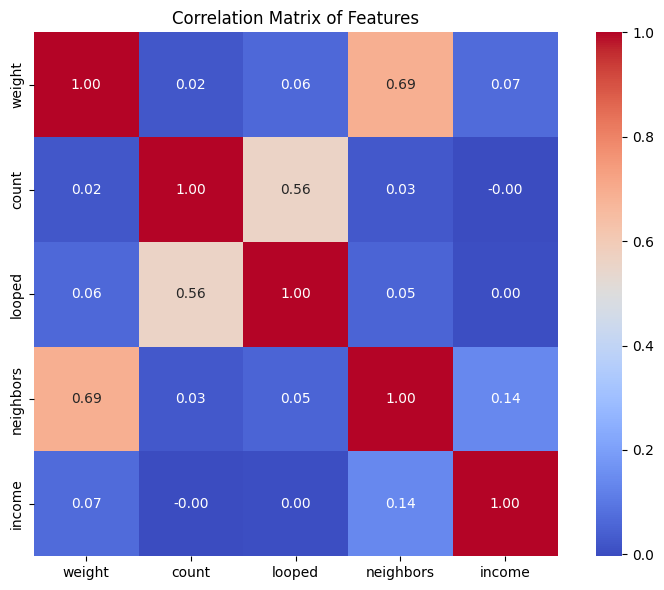

In [9]:
# Compute and visualize correlation matrix
plt.figure(figsize=(8, 6))
corr = df[interested_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()


### Correlation Matrix Insights

The correlation matrix reveals that none of the feature pairs are strongly correlated because no correlation coefficient exceeds the typical threshold of 0.95. 
However, we do observe moderate correlations between some features, for example, `length` and `count` (r ~ 0.70), and `weight` and `neighbors` (r ~ 0.69).

Although these values don't suggest severe multicollinearity, they hint at some overlapping variance in the data. Therefore, we still proceed with PCA — not strictly to reduce dimensionality, but to:
- Explore the structure of the data in a lower dimensional space
- Visualize potential groupings or anomalies
- Prepare for potential use in clustering or anomaly detection

Explained variance ratio per component: [0.28140072 0.21811398]
Cumulative variance explained: [0.28140072 0.4995147 ]


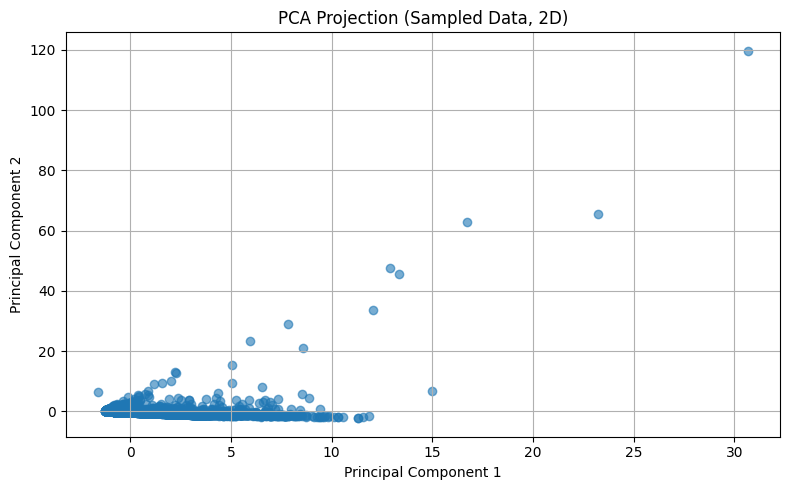

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Select numeric columns (excluding 'address' and categorical features)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numeric_cols].dropna()

# Step 2: Take a random sample to avoid memory errors
X_sample = X.sample(n=20000, random_state=42)

# Step 3: Standardize the sample
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Step 4: Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 5: Show explained variance
print("Explained variance ratio per component:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", np.cumsum(pca.explained_variance_ratio_))

# Step 6: Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection (Sampled Data, 2D)")
plt.grid(True)
plt.tight_layout()
plt.show()


### PCA Results Summary

After applying PCA to a sampled subset of the data, we find that the first two principal components capture nearly 50% of the total variance. This indicates that while some structure is preserved, the original features contribute meaningful variance beyond just two dimensions.

Nevertheless, the PCA projection allows us to make tasks such as clustering, classification, or anomaly detection
The transformation also ensures that the new components are uncorrelated, which can help in models that are sensitive to feature redundancy.

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
from numpy.linalg import inv, LinAlgError

def compute_mahalanobis_anomalies(df, numeric_cols, sample_size=20000, confidence=0.99, id_column="address"):

    # Drop NA from numeric data only
    clean_df = df[numeric_cols + [id_column]].dropna()

    # Sample (if data is large)
    if sample_size is not None and len(clean_df) > sample_size:
        clean_df = clean_df.sample(n=sample_size, random_state=42)


    # Extract just numeric matrix
    data = clean_df[numeric_cols].values

    # Compute mean and inverse covariance
    mean_vec = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)

    try:
        inv_cov_matrix = inv(cov_matrix)
    except LinAlgError:
        raise ValueError("Covariance matrix is singular or not invertible. Check for redundant or constant features.")

    # Mahalanobis distance calculation
    diff = data - mean_vec
    left = np.dot(diff, inv_cov_matrix)
    mahal_sq = np.sum(left * diff, axis=1)
    mahal_dist = np.sqrt(mahal_sq)

    # Chi-squared threshold
    dof = len(numeric_cols)
    threshold = chi2.ppf(confidence, df=dof)

    # Build result DataFrame
    result_df = clean_df.copy()
    result_df["Mahalanobis_Distance"] = mahal_dist
    result_df["Is_anomalies"] = mahal_sq > threshold

    return result_df, threshold


In [12]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
from numpy.linalg import inv, LinAlgError

# Mahalanobis anomalies Function
def compute_mahalanobis_anomalies(df, numeric_cols, sample_size=None, confidence=0.9999, id_column="address"):
    clean_df = df[numeric_cols + [id_column]].dropna()

    if sample_size is not None and len(clean_df) > sample_size:
        clean_df = clean_df.sample(n=sample_size, random_state=42)

    data = clean_df[numeric_cols].values
    mean_vec = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)

    try:
        inv_cov_matrix = inv(cov_matrix)
    except LinAlgError:
        raise ValueError("Covariance matrix is singular or not invertible.")

    diff = data - mean_vec
    mahal_sq = np.sum(np.dot(diff, inv_cov_matrix) * diff, axis=1)
    mahal_dist = np.sqrt(mahal_sq)

    dof = len(numeric_cols)
    threshold = chi2.ppf(confidence, df=dof)

    result_df = clean_df.copy()
    result_df["Mahalanobis_Distance"] = mahal_dist
    result_df["Is_mahalanobis_anomaly"] = mahal_sq > threshold

    return result_df, threshold

# 1D Anomalies Function with IQR, MAD, and STD
def compute_combined_1d_anomalies(df, columns):
    anomaly_flags = pd.Series(False, index=df.index)
    
    for col in columns:
        if col not in df.columns:
            continue
        
        data = df[col].dropna()
        col_flags = pd.Series(True, index=df.index)

        # IQR
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = ((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)).fillna(False)
        col_flags &= iqr_outliers

        # MAD
        median = data.median()
        mad = (np.abs(data - median)).median()
        mad_outliers = (np.abs(df[col] - median) > 3 * mad).fillna(False)
        col_flags &= mad_outliers

        # STD
        mean = data.mean()
        std = data.std()
        std_outliers = ((df[col] < mean - 3 * std) | (df[col] > mean + 3 * std)).fillna(False)
        col_flags &= std_outliers

        anomaly_flags |= col_flags

    return anomaly_flags

# Run anomaly detection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Mahalanobis
result_df, threshold = compute_mahalanobis_anomalies(df, numeric_cols, sample_size=None, confidence=0.999999, id_column="address")

# 1D anomalies
anomalies_1d = compute_combined_1d_anomalies(df, numeric_cols)

# Combine results
result_df["Is_1D_anomaly"] = anomalies_1d.loc[result_df.index]
result_df["Combined_anomaly"] = result_df["Is_mahalanobis_anomaly"] & result_df["Is_1D_anomaly"]

# Display
combined_anomalies = result_df[result_df["Combined_anomaly"]]
print(f"Mahalanobis Threshold: {threshold:.2f}")
print(f"1D anomalies: {anomalies_1d.sum()}  |  Mahalanobis anomalies: {result_df['Is_mahalanobis_anomaly'].sum()}  |  Combined: {len(combined_anomalies)}")
display(combined_anomalies)


Mahalanobis Threshold: 42.70
1D anomalies: 140339  |  Mahalanobis anomalies: 30764  |  Combined: 30764


,year,day,length,weight,count,looped,neighbors,income,address,Mahalanobis_Distance,Is_mahalanobis_anomaly,Is_1D_anomaly,Combined_anomaly
70,2017,139,144,1.03147401694529006200,8973,0,2,64478999.00000000000000000000,115p7UMMngoj1pMvkpHijcRdfJNXj6LrLn,6.55651541858028430454,True,True,True
73,2017,137,144,1.50002019849034007315,9866,0,2,70477658.00000000000000000000,115p7UMMngoj1pMvkpHijcRdfJNXj6LrLn,7.36395190727418746945,True,True,True
173,2016,56,144,0.07812501962549750489,9543,0,1,50000000.00000000000000000000,12524A8PP7PFcDXa9BpGHqhPuVcciCvCn8,7.21605695711967332073,True,True,True
642,2016,62,144,0.13183358705083000895,13462,4092,1,100000000.00000000000000000000,12ePRqvoRkY5biVFPyp6beExAaWiaZWYhm,9.36184452079239726174,True,True,True
909,2016,60,144,0.55161623357711297988,12922,11237,1,400000000.00000000000000000000,12kVzMMhb7DGfj2vfiq1Sm6dUgxygMRFAC,12.62758687639707133599,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916645,2018,330,144,0.52013180270870995603,8037,6430,4,1123600000.00000000000000000000,3MktWPmCkGmfqCPhBQMq3SAWeNExMghqk4,6.98507173637947254008,True,True,True
2916654,2018,330,144,0.19124796187142201198,8247,8247,1,199950000.00000000000000000000,3KAXixb9inBJGyykHzkRKCKj9MkqrRq4fd,8.76364464574197654656,True,True,True
2916667,2018,330,144,0.75450126707903797385,8247,8247,5,2610370000.00000000000000000000,14BGVbLMkaVsax1XTrdBYe5e5AMKj7mscD,8.75473577286707893563,True,True,True
2916680,2018,330,144,0.71745092867229498523,8247,8247,3,1419405817.00000000000000000000,1Fe3MPYLJeb1Fc4d54ff5bjJEUeDgrvAGq,8.75381925775687363966,True,True,True


### Confusion Matrix:

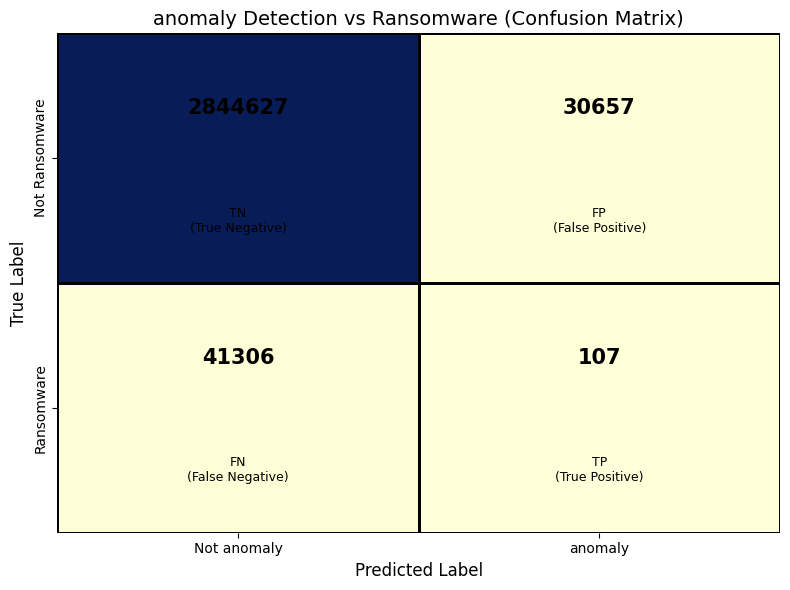

In [13]:
# Add the label column from the original df to result_df
result_df["label"] = df.loc[result_df.index, "label"]

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# True = ransomware if label != "white"
true_labels = (result_df["label"].str.lower() != "white").astype(int)
predicted_labels = result_df["Combined_anomaly"].astype(int)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
labels = ["Not Ransomware", "Ransomware"]
preds = ["Not anomaly", "anomaly"]

# Plot the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=False, fmt="d", cmap="YlGnBu", cbar=False,
                 xticklabels=preds, yticklabels=labels, linewidths=1, linecolor='black')

# Add large bold numbers (the actual values)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j + 0.5, i + 0.3, f"{cm[i, j]}", 
                ha='center', va='center', fontsize=15, fontweight='bold', color="black")
        
        # Add small text below with label
        label_text = (
            "TN\n(True Negative)" if (i, j) == (0, 0) else
            "FP\n(False Positive)" if (i, j) == (0, 1) else
            "FN\n(False Negative)" if (i, j) == (1, 0) else
            "TP\n(True Positive)"
        )
        ax.text(j + 0.5, i + 0.75, label_text, ha='center', va='center', fontsize=9)

# Axis labels and title
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("anomaly Detection vs Ransomware (Confusion Matrix)", fontsize=14)
plt.tight_layout()
plt.show()



Note: The goal of this analysis was to perform general anomaly detection, not ransomware classification.
While some ransomware cases may exhibit statistical anomalies, ransomware itself may follow more complex behavioral patterns or have different defining criteria.
Here, we simply tested whether statistical anomalies in the dataset could be aligned with known ransomware labels.
Most of the benign data was correctly classified as normal (True Negative = 2,844,627).
Very few ransomware samples were caught as anomalies (True Positive = 107 out of ~41,413).
Many ransomware cases were missed (False Negatives = 41,306).
There were also a significant number of false positives (30,657 benign entries incorrectly flagged as anomalies).
These results suggest that while anomalies detection methods are useful for flagging unusual behavior, they are not sufficient alone to detect ransomware reliably.

Number of anomalies detected: 29167


C:\Users\שרבל\AppData\Local\Temp\ipykernel_15024\1230496918.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\שרבל\OneDrive\Desktop\לימודים\מדעי המחשב\אוניברסיטת חיפה\שנה ג\שימוש בשיטות של דאטה סיינס בסייבר\pipeline\data-science-cybersecurity\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


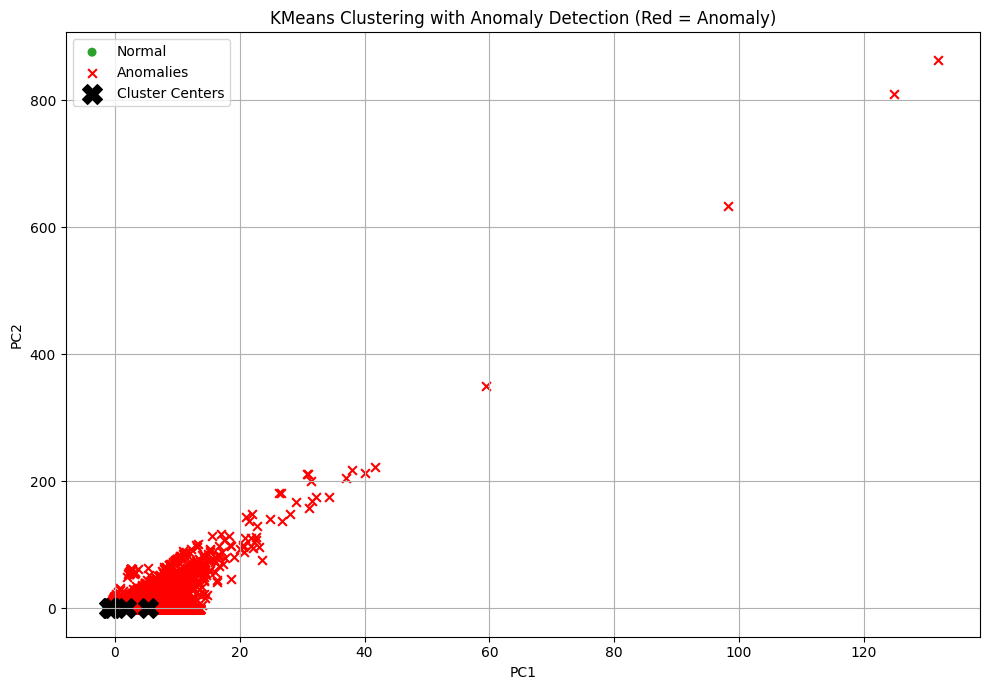

In [14]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Use numeric features only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numeric_cols].dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Distance to cluster center
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[labels], axis=1)

# Threshold (e.g., 99th percentile)
threshold = np.percentile(distances, 99)
anomaly_flags = distances > threshold
print(f"Number of anomalies detected: {np.sum(anomaly_flags)}")

# PCA for 2D visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 7))
plt.title("KMeans Clustering with Anomaly Detection (Red = Anomaly)")

# Normal points
plt.scatter(X_pca[~anomaly_flags, 0], X_pca[~anomaly_flags, 1],
            c=labels[~anomaly_flags], cmap="tab10", s=30, label="Normal")

# Anomalies
plt.scatter(X_pca[anomaly_flags, 0], X_pca[anomaly_flags, 1],
            c="red", s=40, marker="x", label="Anomalies")

# Cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
            c="black", marker="X", s=200, label="Cluster Centers")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\שרבל\AppData\Local\Temp\ipykernel_15024\4198309875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("label").apply(lambda x: x.sample(n=min(len(x), 30), random_state=42)).reset_index(drop=True)


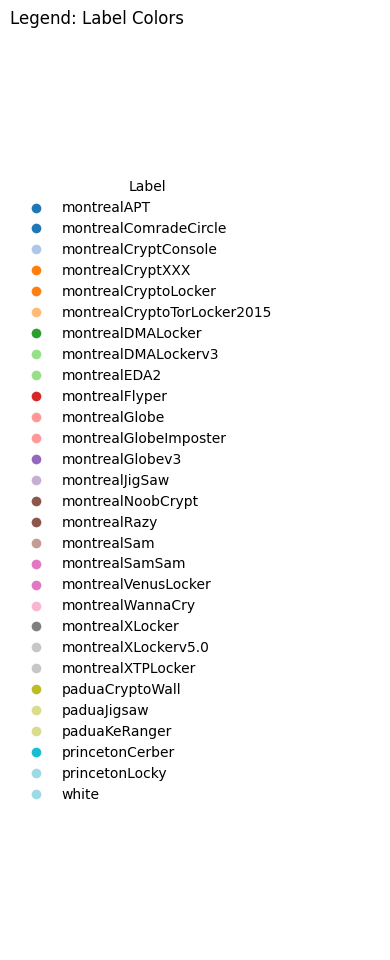

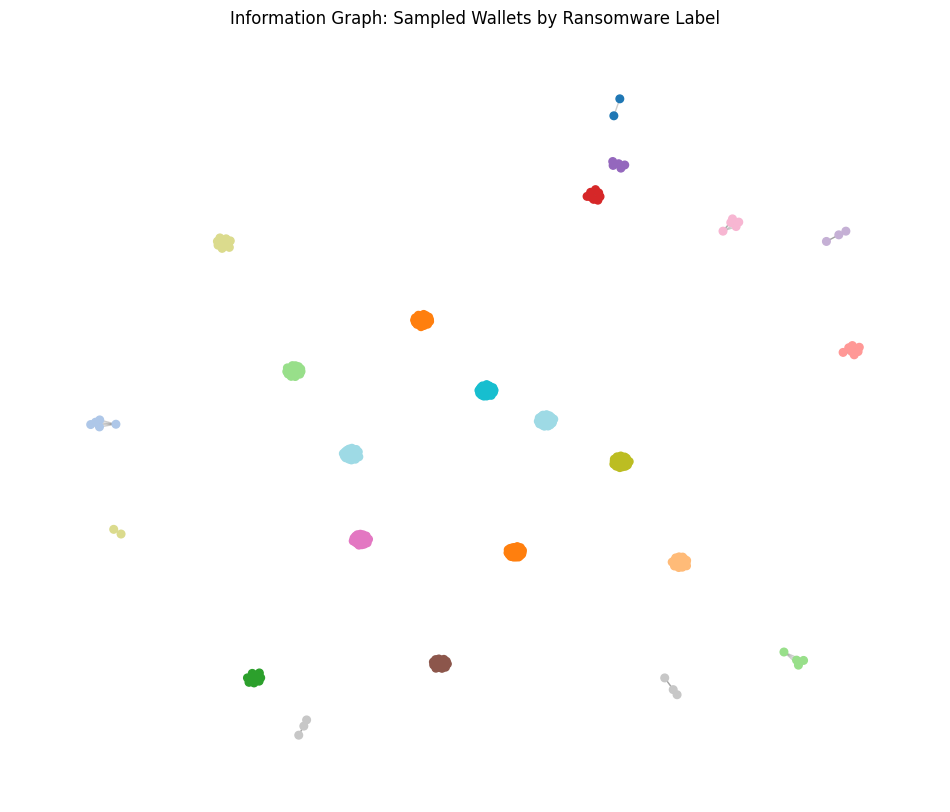

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# Sample limit per label
sampled_df = df.groupby("label").apply(lambda x: x.sample(n=min(len(x), 30), random_state=42)).reset_index(drop=True)

# Build the graph
G_info = nx.Graph()
for label, group in sampled_df.groupby("label"):
    addresses = group["address"].tolist()
    for i in range(len(addresses)):
        for j in range(i + 1, len(addresses)):
            if addresses[i] != addresses[j]:
                G_info.add_edge(addresses[i], addresses[j], label=label)

G_info.remove_edges_from(nx.selfloop_edges(G_info))

# Assign fixed colors to labels
labels = sorted(sampled_df["label"].unique())
cmap = plt.cm.tab20
label_color_map = {label: i for i, label in enumerate(labels)}

# Assign color to each node based on its label
colors = [
    label_color_map[sampled_df[sampled_df["address"] == node]["label"].values[0]]
    if node in sampled_df["address"].values else 0
    for node in G_info.nodes
]
norm_colors = np.array(colors) / max(len(labels) - 1, 1)

# Scene 2: Legend Only
plt.figure(figsize=(4, len(labels) * 0.3 + 1))
legend_elements = []
for label, idx in label_color_map.items():
    color = cmap(idx / max(len(label_color_map) - 1, 1))
    legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                  label=label,
                                  markerfacecolor=color, markersize=8))

plt.legend(handles=legend_elements, title="Label", loc="center left", frameon=False)
plt.axis("off")
plt.title("Legend: Label Colors", loc='left')
plt.tight_layout()
plt.show()

# Scene 1: Graph Plot 
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_info, seed=42)
nodes = nx.draw_networkx_nodes(G_info, pos, node_color=norm_colors, cmap=cmap, node_size=30)
nx.draw_networkx_edges(G_info, pos, alpha=0.2)
plt.title("Information Graph: Sampled Wallets by Ransomware Label")
plt.axis("off")
plt.show()




Each node is a Bitcoin address. A line (edge) is drawn between two nodes if they both appear under the same ransomware label. The graph groups addresses based on co-occurrence in the same ransomeware (label).

Detected 283 anomalies using Z-score.


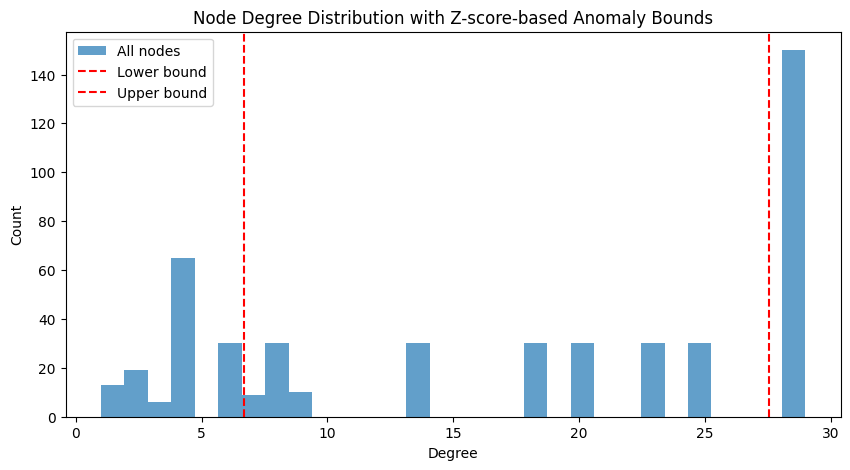

,address,year,day,length,weight,count,looped,neighbors,income,label,degree,Graph_Anomaly
0,35iCvpMMnUWcSWrYtLJLXqe9xo5CYEWRhw,2017,335,2,1.66666666666667007135,1,1,4,390936024.00000000000000000000,montrealAPT,1.00000000000000000000,True
1,35iCvpMMnUWcSWrYtLJLXqe9xo5CYEWRhw,2017,334,144,0.11958333333333699688,2968,0,1,150000000.00000000000000000000,montrealAPT,1.00000000000000000000,True
2,377CY1m8W2qbQQX5HHjziimdh2faGjDeLv,2016,271,6,0.12500000000000000000,1,0,2,100000000.00000000000000000000,montrealAPT,1.00000000000000000000,True
3,377CY1m8W2qbQQX5HHjziimdh2faGjDeLv,2016,278,144,0.30972726211023299259,4882,0,1,1000000000.00000000000000000000,montrealAPT,1.00000000000000000000,True
4,35iCvpMMnUWcSWrYtLJLXqe9xo5CYEWRhw,2017,5,6,0.50000000000000000000,1,0,2,188000000.00000000000000000000,montrealAPT,1.00000000000000000000,True


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Compute node degrees
degree_dict = dict(G_info.degree())
sampled_df["degree"] = sampled_df["address"].map(degree_dict)

# Compute mean and std
mean = sampled_df["degree"].mean()
std = sampled_df["degree"].std()

# Flag anomalies using Z-score
z_thresh = 1  # You can use 2 or 3 depending on desired sensitivity
sampled_df["Graph_Anomaly"] = ((sampled_df["degree"] - mean).abs() > z_thresh * std)

# Display anomalies
graph_anomalies = sampled_df[sampled_df["Graph_Anomaly"]]
print(f"Detected {len(graph_anomalies)} anomalies using Z-score.")

# Plot
lower = mean - z_thresh * std
upper = mean + z_thresh * std

plt.figure(figsize=(10, 5))
plt.hist(sampled_df["degree"], bins=30, alpha=0.7, label="All nodes")
plt.axvline(lower, color='red', linestyle='--', label='Lower bound')
plt.axvline(upper, color='red', linestyle='--', label='Upper bound')
plt.title("Node Degree Distribution with Z-score-based Anomaly Bounds")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.legend()
plt.show()

display(graph_anomalies.head())


We analyzed the node degrees in the wallet graph, where each node represents an address and edges connect addresses associated with the same ransomware label. Using the Z-score method with a threshold of 1, we flagged 283 wallets whose number of connections (degree) was significantly higher or lower than average. These are potential graph anomalies, nodes that behave differently from the rest.

Earlier, we looked at the graph to find ransomware communities. Now we’re flipping it, starting with the outliers to see what makes them stand out. This helps us spot unusual wallets that might play unique roles or reveal hidden connections between ransomware groups.


###  Money laundering analysis

C:\Users\שרבל\AppData\Local\Temp\ipykernel_15024\2364849102.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_df = df.groupby("looped_percentile").apply(
C:\Users\שרבל\AppData\Local\Temp\ipykernel_15024\2364849102.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("looped_percentile").apply(
C:\Users\שרבל\AppData\Local\Temp\ipykernel_15024\2364849102.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

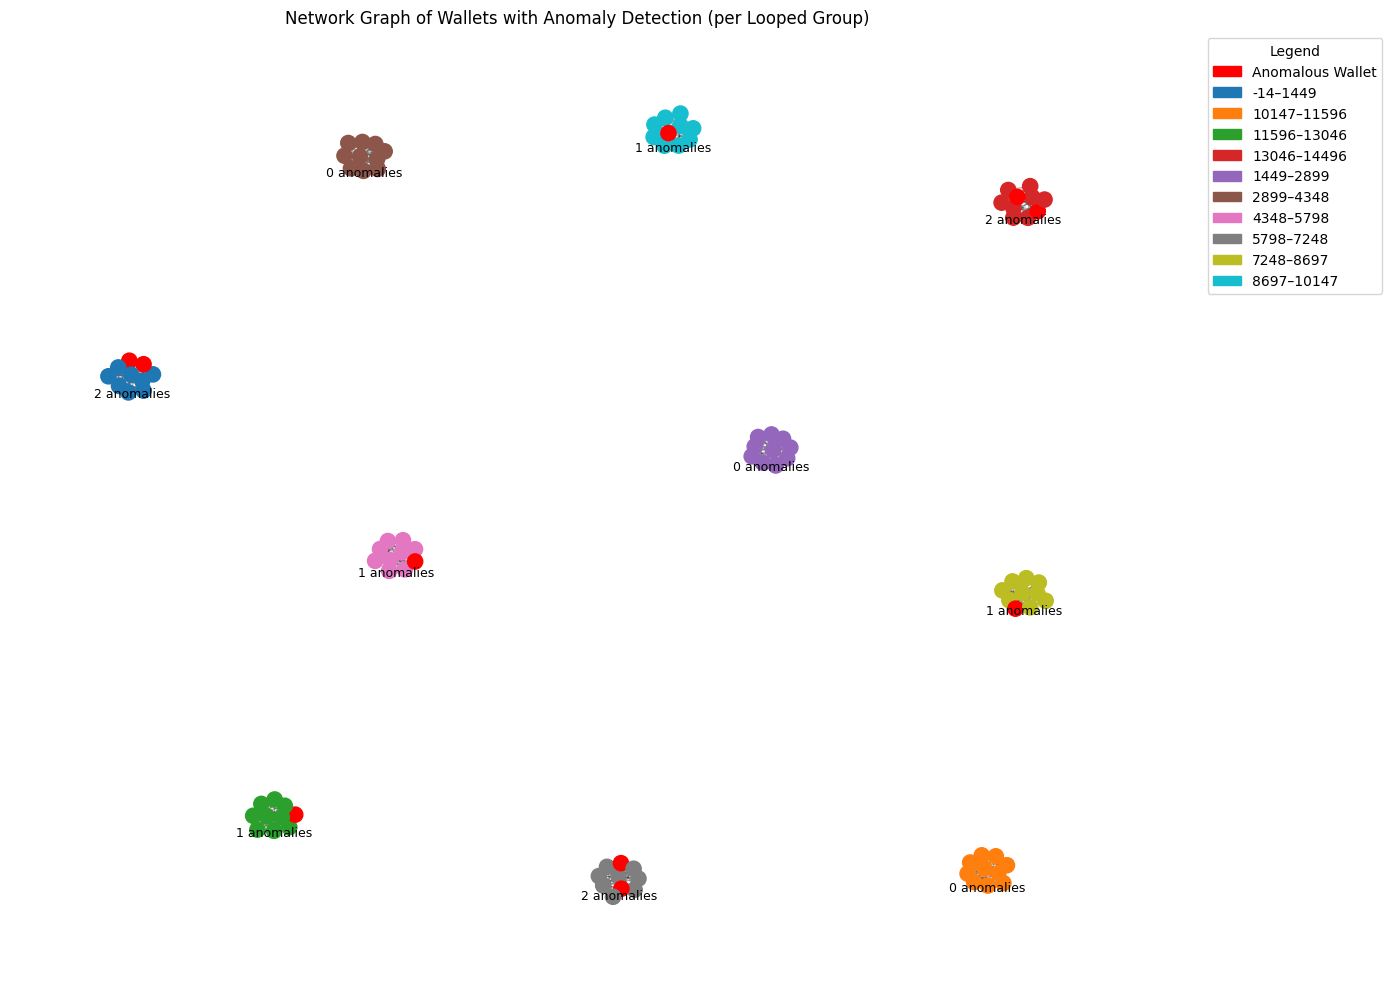

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.ensemble import IsolationForest

# Bin 'looped' into 10 equal-width groups
df["looped_percentile"] = pd.cut(df["looped"], bins=10)
intervals = df["looped_percentile"].cat.categories
labels = [f"{int(p.left)}–{int(p.right)}" for p in intervals]
df["looped_percentile"] = df["looped_percentile"].cat.rename_categories(labels)

# Sample up to 10 wallets from each group
sampled_df = df.groupby("looped_percentile").apply(
    lambda x: x.sample(min(len(x), 10), random_state=42)
).reset_index(drop=True)

# Run Isolation Forest on key behavioral features
features = sampled_df[["looped", "count", "income", "neighbors"]].fillna(0)
model = IsolationForest(contamination=0.1, random_state=42)
sampled_df["anomaly"] = model.fit_predict(features)  # -1 = anomaly

# Build graph (nodes = wallets, edges = within-group connections)
G = nx.Graph()
for group, group_df in sampled_df.groupby("looped_percentile"):
    addresses = group_df["address"].tolist()
    for i in range(len(addresses)):
        for j in range(i + 1, len(addresses)):
            G.add_edge(addresses[i], addresses[j], group=group)

# Prepare node colors: red = anomaly, else group color
cluster_labels = sampled_df.set_index("address")["looped_percentile"].to_dict()
anomaly_labels = sampled_df.set_index("address")["anomaly"].to_dict()
unique_groups = sorted(df["looped_percentile"].dropna().unique())
group_color_map = {grp: i for i, grp in enumerate(unique_groups)}
colors = [
    'red' if anomaly_labels.get(n) == -1 else plt.cm.tab10(group_color_map.get(cluster_labels.get(n)))
    for n in G.nodes
]

# Draw graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(14, 10))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=120)
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Annotate anomaly count under each group cluster
for group in unique_groups:
    group_nodes = [n for n in G.nodes if cluster_labels.get(n) == group]
    if group_nodes:
        # Position: center of cluster
        group_pos = np.mean([pos[n] for n in group_nodes], axis=0)
        # Count anomalies
        anomaly_count = sum(anomaly_labels.get(n) == -1 for n in group_nodes)
        # Show count
        plt.text(group_pos[0], group_pos[1] - 0.05, f"{anomaly_count} anomalies",
                 fontsize=9, ha='center', color='black')

# Legend
legend_handles = [
    mpatches.Patch(color='red', label='Anomalous Wallet'),*[mpatches.Patch(color=plt.cm.tab10(group_color_map[g]), label=str(g)) for g in unique_groups]]
plt.legend(handles=legend_handles, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Network Graph of Wallets with Anomaly Detection (per Looped Group)")
plt.axis("off")
plt.tight_layout()
plt.show()


Each group in this graph represents a range of looped behavior. To detect suspicious wallets within each group, i used Isolation Forest.
In the network graph, each wallet is a node. Red nodes represent wallets that were flagged as anomalous, wallets whose combination of behavior doesn't fit the typical pattern in their group. Under each group cluster, i display how many such anomalies were detected. This lets us visually spot clusters that may contain abnormal or high-risk activity.

I chose to group wallets by looped because it's a key behavioral feature strongly linked to money laundering patterns. Grouping by looped allows us to compare wallets with similar laundering complexity and spot outliers within each behavioral tier.

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    783047
           1       0.08      0.58      0.14      6282

    accuracy                           0.94    789329
   macro avg       0.54      0.77      0.56    789329
weighted avg       0.99      0.94      0.96    789329

Random Forest predicted 44856 wallets as ransomware.
Some of suspicious wallets:
1959818    1LrxHzwRbtMtB9veVMGYdEKFR86wdQRYx1
2530913    3FTjcvGtLSKrGZjm8PFqwM3pjACLowY9MP
1202829    1DYXRxySEbPppQ45Qt85pwWGW1HmySKoRG
2392545    32mtvAvmzG4Hmo2gDBdKHanRHVQEV9CP7d
2189345    1P5ZXc29qnFp411V9imgmsXXH9DCyrfBa7
Name: address, dtype: object


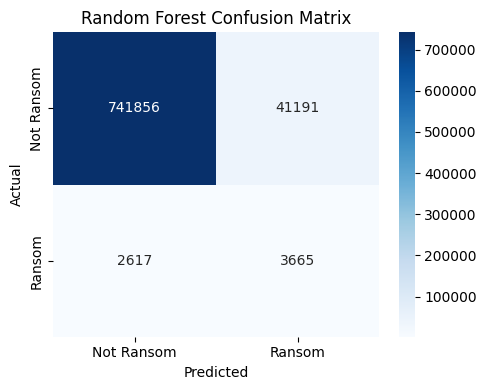


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    783047
           1       0.05      0.82      0.09      6282

    accuracy                           0.86    789329
   macro avg       0.52      0.84      0.50    789329
weighted avg       0.99      0.86      0.92    789329

XGBoost predicted 114201 wallets as ransomware.
Some of suspicious wallets:
1959818    1LrxHzwRbtMtB9veVMGYdEKFR86wdQRYx1
368816     15WhLHbY5JSPAHWnnNfdfReKJEgjWUH3Rz
2130624    1NWcca1SeBayXRmpT64nvuPLW6dp6Jkbvx
2530913    3FTjcvGtLSKrGZjm8PFqwM3pjACLowY9MP
1202829    1DYXRxySEbPppQ45Qt85pwWGW1HmySKoRG
Name: address, dtype: object


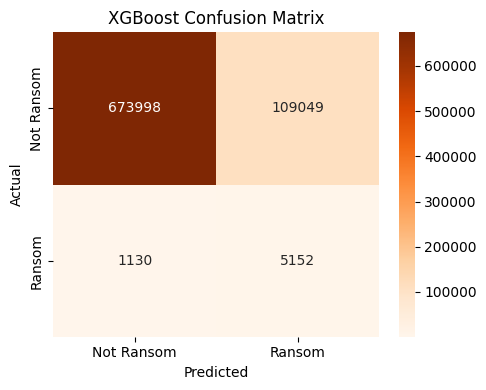

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


df = df.sample(frac=1.0, random_state=42)  # Use 20% of the data for speed

# Create timestamp from year + day
df['timestamp'] = pd.to_datetime(df['year'].astype(str), format='%Y') + pd.to_timedelta(df['day'] - 1, unit='D')
df = df.sort_values(by=["address", "timestamp"])

# Temporal features
temporal_df = df.groupby("address").agg(
    first_seen=('timestamp', 'min'),
    last_seen=('timestamp', 'max'),
    n_days_active=('timestamp', lambda x: (x.max() - x.min()).days + 1),
    tx_count=('timestamp', 'count')
).reset_index()
temporal_df['tx_per_day'] = temporal_df['tx_count'] / temporal_df['n_days_active'].replace(0, 1)

# Behavioral features
wallet_df = df.drop_duplicates("address")[['address', 'income', 'neighbors', 'looped', 'count', 'label']]
merged = wallet_df.merge(temporal_df, on='address')

# Binary target: 1 = ransomware wallet, 0 = non-ransomware
merged['target'] = merged['label'].apply(lambda x: 1 if x != 'white' else 0)

# Final dataset
X = merged[['income', 'neighbors', 'looped', 'count', 'n_days_active', 'tx_count', 'tx_per_day']]
y = merged['target']
addresses = merged['address']  # Save for later

# Train/test split
X_train, X_test, y_train, y_test, addr_train, addr_test = train_test_split(X, y, addresses, test_size=0.3, random_state=42)
# RANDOM FOREST:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, rf_preds))

# Print detected ransomware wallets
rf_ransom_addrs = addr_test[rf_preds == 1]
print(f"Random Forest predicted {len(rf_ransom_addrs)} wallets as ransomware.")
print("Some of suspicious wallets:")
print(rf_ransom_addrs.head())

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Ransom", "Ransom"],
            yticklabels=["Not Ransom", "Ransom"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# XGBOOST:
scale_ratio = (y == 0).sum() / (y == 1).sum()
xgb = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_ratio)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("\nXGBoost Results:")
print(classification_report(y_test, xgb_preds))

# Print detected ransomware wallets
xgb_ransom_addrs = addr_test[xgb_preds == 1]
print(f"XGBoost predicted {len(xgb_ransom_addrs)} wallets as ransomware.")
print("Some of suspicious wallets:")
print(xgb_ransom_addrs.head())

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, xgb_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Not Ransom", "Ransom"],
            yticklabels=["Not Ransom", "Ransom"])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


i tried to train a machine learning model to detect ransomware Bitcoin wallets based on their behavior and activity patterns. By analyzing wallet features like income, transaction count, network size, and how long a wallet was active, we used Random Forest and XGBoost to flag suspicious wallets. Although our current model is accurate overall, it still struggles to catch ransomware wallets due to data imbalance.


### Lets Sum it up

- The models capture clear patterns in the data, especially for non-ransomware wallets. Their overall accuracy is good, and by applying balanced weights and reviewing prediction distributions, we gain insights into how the features separate normal from suspicious wallets.

- The fit is strong for the majority (non-ransomware class).
Initially, the models struggled to detect ransomware wallets due to class imbalance, but after applying class_weight='balanced', the recall for the ransomware class improved significantly. This shows the model is learning to recognize anomalies better, though there's still many things to improve.

- The models are explainable, and the models we chose are relatively interpretable. We used classification reports, confusion matrices, and printed predictions to understand the model's behavior. We identified which wallets were flagged and could analyze them further, making the models partially explainable and useful for cybersecurity analysts.



### Review and improvement suggestions for my code:
I suggest to upgrade the models by using more advanced algorithms or tuning them to better detect ransomware patterns. I also suggest to enhance the segmentation of user behavior to uncover hidden patterns, and to adopt a modular or federated system design to improve scalability, flexibility, and data privacy.
I suggest to display the data in multiple visual and statistical forms to better detect anomalies using both one dimensional and multi dimensional perspectives.